# DATS369: Machine Learning with Graphs Homework 2
Due: Mar 29 23:59, 2025

In this work, let's dive into graph neural networks! Try running your code on NYU Greene.

In [1]:
# setup device at the very beginning
import torch 

# if torch.backends.mps.is_available():
#     device = "mps"
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# 1. Node Classification based on GNNs (65 points)
## 1.1 Node Feature Preparation (5 points)
Show your code below

In [2]:
# for CLIP 
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model = clip_model.to(device)

def embed_clip(batch, model=clip_model, processor=clip_processor):
    inputs = processor(images=batch, return_tensors="pt").to(model.device)

    with torch.no_grad():
        embs = model.get_image_features(**inputs)
    
    return embs

/Users/ricercar/miniconda3/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# for CNN-based Image Classifier 
import sys
import os
sys.path.append(os.path.abspath(".."))  # import files from HW1

from HW1.Q3 import CNN, MVModel

class CNNFeatureExtractor:
    def __init__(self):
        self.features = None 
    
    def hook(self, module, input, output):
        self.features = output 

extractor = CNNFeatureExtractor()

parent_dir = os.path.dirname(os.getcwd())
ckpt_path = os.path.join(parent_dir, "HW1/checkpoints/cnn-e30-bs32-lr0.0001/epoch=29-val_acc=0.18.ckpt")
cnn_model = MVModel.load_from_checkpoint(ckpt_path, model_type='cnn')

pen_layer = cnn_model.model.model[-2] # locate thhe penultimate layer
pen_layer.register_forward_hook(extractor.hook)

cnn_model = cnn_model.to(device)
    
def embed_cnn(batch, model=cnn_model, extractor=extractor):
    with torch.no_grad():
        _ = model(batch)
        embs = extractor.features
    
    return embs

In [4]:
# get the features
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

feature_cache_dir = "features"
os.makedirs(feature_cache_dir, exist_ok=True)

try:
    features_clip = torch.load(os.path.join(feature_cache_dir, "clip.pt"))
    features_cnn = torch.load(os.path.join(feature_cache_dir, "cnn.pt"))
    print("Features are loaded from cache")
except:
    # load the data and compute features
    parent_dir = os.path.dirname(os.getcwd())
    images_dir = os.path.join(parent_dir, "HW1/data/sub_images")

    image_names = sorted(os.listdir(images_dir), key=lambda x: int(x.split('.')[0]))

    transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor()
                            ])

    images = []
    for image_name in tqdm(image_names, desc="Loading images"):
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)

        if image.mode != "RGB":
            image = image.convert("RGB")
        
        image = transform(image)
        images.append(image)

    images = torch.stack(images)

    batch_size = 32

    features_clip = []
    features_cnn = []

    for batch_idx in tqdm(range(0, len(images), batch_size), desc="Getting feature embeddings"):
        batch = images[batch_idx: batch_idx+batch_size]
        clip = embed_clip(batch)
        cnn = embed_cnn(batch)

        features_clip.append(clip)
        features_cnn.append(cnn)

    features_clip = torch.cat(features_clip, dim=0)
    features_cnn = torch.cat(features_cnn, dim=0)

    torch.save(features_clip, os.path.join(feature_cache_dir, "clip.pt"))
    torch.save(features_cnn, os.path.join(feature_cache_dir, "cnn.pt"))
    print("Features saved to cache")

Features are loaded from cache


## 1.2 Implementing GCN for Product Classification (20 points)
## Code implementation (15 points)
Given the adjacency matrix $A$ and node feature matrix $X$, the layer-wise GCN updating rule is: $H=\text{ReLU}(AXW)$. $W$ is the model parameter, $H$ represents the hidden representation. 

In [5]:
# we need to install the following packages
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score
import scipy.sparse as sp
import numpy as np

In [6]:
class GraphConvolution(nn.Module):
    """GCN layer: refer to https://github.com/tkipf/pygcn
    
    parameters
    ----------
    in_features : input feature dimension
    out_features : output dimension
    with_bias: bias term 
    """

    def __init__(self, in_features, out_features, with_bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if with_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self): 
        """param initialization"""
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """forward pass, AXW
        x: node feature tensor
        adj: sparse tensor
        """

        ######################################
        # write your code here (don't forget to include the bias term with self.bias argument)

        h = torch.mm(x, self.weight)
        output = torch.spmm(adj, h)

        if self.bias is not None:
            output = output + self.bias

        ######################################
        return output # AXW

In [7]:
class GCN(nn.Module):
    """ 2 GNN layers
    
    parameters
    ----------
    nfeat : input dimension
    nhid : hidden dimension
    nclass : output dimension, or number of class
    dropout : dropout ratio
    with_bias: bias term
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):

        super(GCN, self).__init__()

        self.nfeat = nfeat
        self.nclass = nclass
        self.gc1 = GraphConvolution(nfeat, nhid, with_bias=with_bias)
        self.gc2 = GraphConvolution(nhid, nclass, with_bias=with_bias)
        self.dropout = dropout

    def forward(self, x, adj):
        ######################################
        # write your code here 
        # hint: you can use F.dropout() function to define dropout 
        h = F.relu(self.gc1(x, adj))
        h = F.dropout(h, p=self.dropout, training=self.training)
        predicts = self.gc2(h, adj)

        ######################################
        return F.log_softmax(predicts, dim=1)

In [8]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix, dense_to_sparse
from scipy.sparse import coo_matrix
import torch 

parent_dir = os.path.dirname(os.getcwd())
dataset_dir = os.path.join(parent_dir, "HW1/data/Movies.pt")

graph = torch.load(dataset_dir, weights_only=False) # create a "Movies" folder and download the Movies dataset from the google drive. 
adj = graph['adj']
label = graph['label']
train_index = graph['train']
val_index = graph['val']
test_index = graph['test']

# # hint: to use torch_geometric package, the graph input should follow the standard formats. You can try with "Cora" dataset below to understand how to transform Amazon Movies to the required format
# dataset = Planetoid(root='./data', name='Cora') # dataset download automatically
# data = dataset[0]
# adj = to_scipy_sparse_matrix(data.edge_index)
# features = data.x
# labels = data.y

In [9]:
# data.edge_index

In [10]:
edge_index = torch.tensor(adj).nonzero().t().contiguous()

data_clip = Data(
    x=features_clip,
    y=torch.tensor(label),
    edge_index=edge_index,
    train_mask=train_index,
    val_mask=val_index,
    test_mask=test_index
)

data_cnn= Data(
    x=features_cnn,
    y=torch.tensor(label),
    edge_index=edge_index,
    train_mask=train_index,
    val_mask=val_index,
    test_mask=test_index
)

dataset = {
    "data_clip": data_clip,
    "data_cnn": data_cnn
}

In [11]:
# adj = coo_matrix(adj, dtype=np.float32) # turn our adj to scipy sparse matrix
# labels = torch.tensor(label)

To build GCN, we need to normalize the adj ： 

$A \leftarrow A + I$

$\hat{A}= D^{-1/2}{A}D^{-1/2}$ 

In [12]:
def normalize_adj(mx):
    """normalization: A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    """
    mx = mx + sp.eye(mx.shape[0]) # A = A + I
    rowsum = np.array(mx.sum(1)) 
    r_inv = np.power(rowsum, -1/2).flatten()
    r_inv[np.isinf(r_inv)] = 0. 
    r_mat_inv = sp.diags(r_inv) 
    ######################################
    # write your code here 

    mx = r_mat_inv @ mx @ r_mat_inv
    ######################################
    return mx

In [13]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """convert scipy.sparse matrix to torch sparse tensor,
       we need three arugments, row, col and data, coresponding to
       edge_index and edge_weight
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    sparserow = torch.LongTensor(sparse_mx.row).unsqueeze(1) # 
    sparsecol = torch.LongTensor(sparse_mx.col).unsqueeze(1) # 
    sparseconcat = torch.cat((sparserow, sparsecol), 1) # 
    sparsedata = torch.FloatTensor(sparse_mx.data)  # 
    return torch.sparse.FloatTensor(sparseconcat.t(), sparsedata, torch.Size(sparse_mx.shape)) # construct sparse tensor

In [14]:
# def train(model, data, adj, lr=0.01, weight_decay=5e-4, epochs=200):
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     labels = data.y
#     train_mask = data.train_mask

#     for i in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         output = model(data.x, adj)

#         loss = F.nll_loss(output[train_mask], labels[train_mask]) # compute training loss

        
#         loss.backward()
#         optimizer.step()

#         if i % 10 == 0:
#             print('Epoch {}, training loss: {}'.format(i, loss.item()))

def train(model, data, adj, lr=0.01, weight_decay=5e-4, epochs=200, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    labels = data.y
    train_mask = data.train_mask 

    best_val_acc = 0
    best_val_epoch = 0
    best_model_state = None
    patience_counter = 0

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data.x, adj)

        loss = F.nll_loss(output[train_mask], labels[train_mask]) # compute training loss

        
        loss.backward()
        optimizer.step()

        # validate each epoch
        _, _, acc_val, loss_val = validation(model, data, adj, verbose=False)


        if i % 10 == 0:
            print(f"Epoch {i}, training loss: {loss.item()}, val loss: {loss_val}, val_acc: {acc_val}")
            # print('Epoch {}, training loss: {}, '.format(i, loss.item()))

        # early stopping
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_val_epoch = i
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {best_val_epoch} with validation accuracy {best_val_acc:4f}")
            break

    if best_model_state is not None: 
        model.load_state_dict(best_model_state)

@torch.no_grad()
def test(model, data, adj):
    """test the performance"""
    model.eval() # eval() 
    test_mask = data.test_mask
    labels = data.y 
    output = model(data.x, adj) #  
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) #  
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() #  
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()

@torch.no_grad()
def validation(model, data, adj, verbose=True):
    """add a validation for early stopping"""
    model.eval() # eval() 
    val_mask = data.val_mask
    labels = data.y 
    output = model(data.x, adj) #  
    loss_val = F.nll_loss(output[val_mask], labels[val_mask])
    preds = output[val_mask].argmax(1) #  
    acc_val= preds.eq(labels[val_mask]).cpu().numpy().mean() #  
    
    if verbose:
        print("Val set results:",
            "loss= {:.4f}".format(loss_val.item()),
            "accuracy= {:.4f}".format(acc_val))
    return preds, output, acc_val.item(), loss_val.item()

## Train GCN model and test your model and report your results (5 points) 

In [15]:
gcn_models = {}
for name, data in dataset.items():
    print(f"Training GCN with {name}")

    num_nodes = data.x.shape[0]
    adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=num_nodes)
    adj_norm = sparse_mx_to_torch_sparse_tensor(adj)

    features = data.x
    labels = data.y

    nclass = labels.max().item()+1
    gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
    gcn = gcn.to(device)
    data = data.to(device)
    adj_norm = adj_norm.to(device)
    train(gcn, data, adj_norm, lr=0.001, epochs=5000, patience=1000)

    gcn_models[name] = gcn

    print("="*20)

Training GCN with data_clip
Epoch 0, training loss: 35.99372100830078, val loss: 30.00778579711914, val_acc: 0.04
Epoch 10, training loss: 8.85456657409668, val loss: 7.337459087371826, val_acc: 0.04363636363636364
Epoch 20, training loss: 3.043886661529541, val loss: 3.012892007827759, val_acc: 0.030303030303030304


/var/folders/4c/h1pj207x7bx25b8wfdz4fg8w0000gn/T/ipykernel_97954/2683752846.py:11: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  return torch.sparse.FloatTensor(sparseconcat.t(), sparsedata, torch.Size(sparse_mx.shape)) # construct sparse tensor


Epoch 30, training loss: 3.004514455795288, val loss: 3.0093605518341064, val_acc: 0.05454545454545454
Epoch 40, training loss: 3.0041542053222656, val loss: 3.008765697479248, val_acc: 0.05454545454545454
Epoch 50, training loss: 3.0033345222473145, val loss: 3.008046865463257, val_acc: 0.05454545454545454
Epoch 60, training loss: 3.0030012130737305, val loss: 3.0072085857391357, val_acc: 0.05454545454545454
Epoch 70, training loss: 3.0028178691864014, val loss: 3.0068724155426025, val_acc: 0.05454545454545454
Epoch 80, training loss: 3.0021421909332275, val loss: 3.0061416625976562, val_acc: 0.05454545454545454
Epoch 90, training loss: 3.0013113021850586, val loss: 3.0055134296417236, val_acc: 0.05454545454545454
Epoch 100, training loss: 3.001465082168579, val loss: 3.004864454269409, val_acc: 0.05454545454545454
Epoch 110, training loss: 2.9988272190093994, val loss: 3.0029895305633545, val_acc: 0.05454545454545454
Epoch 120, training loss: 3.0006885528564453, val loss: 3.003564357

In [16]:
# test models
for name, model in gcn_models.items():
    print(f"Testing GCN with {name}")
    data = dataset[name]

    num_nodes = data.x.shape[0]
    adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=num_nodes)
    adj_norm = sparse_mx_to_torch_sparse_tensor(adj)

    test(model, data, adj_norm)
    print("="*20)

Testing GCN with data_clip
Test set results: loss= 2.9625 accuracy= 0.0267
Testing GCN with data_cnn
Test set results: loss= 3.7026 accuracy= 0.0462


In [17]:
# adj_norm = sparse_mx_to_torch_sparse_tensor(adj)
# nclass = labels.max().item()+1
# gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
# # move the model and data from CPU to GPU
# # device = 'cpu' # device ='cuda'
# gcn = gcn.to(device)
# data = data.to(device)
# adj_norm = adj_norm.to(device)
# train(gcn, data, adj_norm, epochs=100)

# 1.2. Implementing GAT for Product Classification (20 points)

## Code implementation (15 points)

Each GAT layer is upadted as:

$$\mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
\sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j}$$

The attention score between node i and j is defined as:

$$\alpha_{i,j} =
\frac{
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
[\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
\right)\right)}.$$

In [18]:
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.nn.inits import glorot, zeros
import torch.optim as optim

class GATConv(MessagePassing):
    """
    parameters
    ------   
    in_channels: input neural channels
    out_channels: output neural channels
    heads: the number of multi-head
    concat: How to combine multiple heads? Concat or pooling? 
    negative_slope: parameter for LeakyReLU activation
    dropout: dropout ratio
    bias: bias term
    """

    def __init__(self, in_channels,
                 out_channels, heads=1, concat=True,
                 negative_slope=0.2, dropout=0.0,
                 bias=True, **kwargs):
        
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin = Linear(in_channels, heads * out_channels,
                              bias=False, weight_initializer='glorot')

        # attention parameters
        self.att = Parameter(torch.Tensor(1, heads, 2*out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)


        self.reset_parameters()

    def reset_parameters(self):
        """param initialization"""
        self.lin.reset_parameters()
        glorot(self.att)
        zeros(self.bias)
    
    def forward(self, x, edge_index, size=None):
        """forward pass"""
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        x = self.lin(x)
        output = self.propagate(edge_index, size=size, x=x) # 
        
        if self.concat is True:
            #################
            #### write your code here  ####
            output = output.view(-1, self.heads * self.out_channels)
            ################
        else:
            #################
            #### write your code here  ####
            output = output.mean(dim=1) # average heads
            ################

        if self.bias is not None:
            output = output + self.bias
        return output

    def message(self, edge_index_i, x_i, x_j, size_i):
        """compute attentin score
    
        parameters
        ----
        edge_index_i: the first dimension of edge index, the neighbors of x_i 
        x_i: source nodes' features
        x_j: target nodes' features
        size_i: source node size
        """
        
        ###############################################
        #### write your code here, compute alpha score before softmax####

        
        alpha = torch.cat([x_i, x_j], dim=-1)
        alpha = alpha.view(-1, self.heads, 2*self.out_channels) # reshape to (num_edges, heads, 2*out_channels)


        # print(f"x_i shape: {x_i.shape}")   # Expected: (num_edges, heads, out_channels)
        # print(f"x_j shape: {x_j.shape}")   # Expected: (num_edges, heads, out_channels)
        # print(f"alpha shape: {alpha.shape}")  # Should be (num_edges, heads, 2*out_channels)
        # print(f"self.att shape: {self.att.shape}")

        alpha = (alpha * self.att).sum(dim=-1)
        alpha = F.leaky_relu(alpha, self.negative_slope)
        ###############################################
        
        alpha = softmax(src=alpha, index=edge_index_i, num_nodes=size_i)
        
        # apply dropout to alpha 
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        
        ##################################
        #### write your code here, obtaining the return output ####
        #################################
        return alpha.unsqueeze(-1) * x_j.view(-1, self.heads, self.out_channels)

In [19]:
class GAT(torch.nn.Module):
    """ 2 GAT layers.
    
    parameters
    ----------
    nfeat : input dimension
    nhid : hidden dimensions
    nclass : number of classes
    heads: attention heads
    output_heads: the heads in output layer
    dropout : dropout ratio
    with_bias: bias term
    """

    def __init__(self, nfeat, nhid, nclass, heads=8, output_heads=1, dropout=0.5, with_bias=True):

        super(GAT, self).__init__()

        self.conv1 = GATConv(
            nfeat,
            nhid,
            heads=heads,
            dropout=dropout,
            bias=with_bias)

        self.conv2 = GATConv(
            nhid * heads,
            nclass,
            heads=output_heads,
            concat=False,
            dropout=dropout,
            bias=with_bias)

        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index)) # 
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def initialize(self):
        """parameter initialization.
        """
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

In [20]:
def train(model, data, lr=0.01, weight_decay=5e-4, epochs=200, patience=5):
    """train the model"""
    #################
    #### write your code here ####
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    labels = data.y
    train_mask = data.train_mask 

    best_val_acc = 0
    best_val_epoch = 0
    best_model_state = None
    patience_counter = 0

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output[train_mask], labels[train_mask]) # compute training loss

        
        loss.backward()
        optimizer.step()

        # validate each epoch
        _, _, acc_val, loss_val = validation(model, data, verbose=False)


        if i % 10 == 0:
            print(f"Epoch {i}, training loss: {loss.item()}, val loss: {loss_val}, val_acc: {acc_val}")
            # print('Epoch {}, training loss: {}, '.format(i, loss.item()))

        # early stopping
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_val_epoch = i
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {best_val_epoch} with validation accuracy {best_val_acc:4f}")
            break

    if best_model_state is not None: 
        model.load_state_dict(best_model_state)

    ################

@torch.no_grad()
def test(model, data):
    """test the performance"""
    #################
    #### write your code here ####
    model.eval() # eval() 
    test_mask = data.test_mask
    labels = data.y 
    output = model(data) #  
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) #  
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() #  
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()
    ################

@torch.no_grad()
def validation(model, data, verbose=True):
    """add a validation for early stopping"""
    model.eval() # eval() 
    val_mask = data.val_mask
    labels = data.y 
    output = model(data) #  
    loss_val = F.nll_loss(output[val_mask], labels[val_mask])
    preds = output[val_mask].argmax(1) #  
    acc_val= preds.eq(labels[val_mask]).cpu().numpy().mean() #  
    
    if verbose:
        print("Val set results:",
            "loss= {:.4f}".format(loss_val.item()),
            "accuracy= {:.4f}".format(acc_val))
    return preds, output, acc_val.item(), loss_val.item()


## Train GAT model and test your model and report your results (5 points)

In [21]:
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid(root='./data', name='Cora') # 
# data = dataset[0]
# nclass = data.y.max().item()+1

gat_models = {}
for name, data in dataset.items():
    print(f"Training GAT with {name}")

    features = data.x
    labels = data.y

    nclass = labels.max().item()+1

    gat = GAT(nfeat=data.x.shape[1],
        nhid=8, heads=8, nclass=nclass)
    gat = gat.to(device)
    data = data.to(device)
    train(gat, data, lr=0.001, epochs=5000, patience=1000)

    gat_models[name] = gat

    print("="*20)

Training GAT with data_clip
Epoch 0, training loss: 3.7320942878723145, val loss: 3.166841745376587, val_acc: 0.03151515151515152
Epoch 10, training loss: 3.060434103012085, val loss: 2.984902858734131, val_acc: 0.06060606060606061
Epoch 20, training loss: 3.0288753509521484, val loss: 2.994938373565674, val_acc: 0.02909090909090909
Epoch 30, training loss: 3.0032763481140137, val loss: 2.9747159481048584, val_acc: 0.08
Epoch 40, training loss: 2.9837636947631836, val loss: 2.9673240184783936, val_acc: 0.10787878787878788
Epoch 50, training loss: 2.9738552570343018, val loss: 2.9596495628356934, val_acc: 0.11393939393939394
Epoch 60, training loss: 2.9568281173706055, val loss: 2.951387882232666, val_acc: 0.08727272727272728
Epoch 70, training loss: 2.966040849685669, val loss: 2.949796676635742, val_acc: 0.0993939393939394
Epoch 80, training loss: 2.9473276138305664, val loss: 2.943307876586914, val_acc: 0.13090909090909092
Epoch 90, training loss: 2.9319992065429688, val loss: 2.9431

In [22]:
# test models
for name, model in gat_models.items():
    print(f"Testing GAT with {name}")
    data = dataset[name]

    test(model, data)
    print("="*20)

Testing GAT with data_clip
Test set results: loss= 2.6825 accuracy= 0.1649
Testing GAT with data_cnn


Test set results: loss= 3.5012 accuracy= 0.2126


# 1.3. Implementing GraphSAGE for Product Classification (20 points)

## Code implementation (15 points)
The key component of GraphSAGE is sampling. We will use the NeighborSampler in PyG to implement this function

Please note that there are two weight matrices in GraphSAGE 

$$ \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j
$$

In [23]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler
# dataset = Planetoid(root='./data', name='Cora') # 
# data = dataset[0]
# nclass = data.y.max().item()+1

# sizes=[10,5] # 
# train_idx = torch.arange(data.num_nodes)[data.train_mask]
# train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
#                                sizes=sizes, batch_size=128,
#                                shuffle=True, num_workers=0) 

In [24]:
dummy_data = dataset["data_clip"] # the dataset i wrote, not the Planetoid
nclass = dummy_data.y.max().item()+1

sizes=[10,5]
train_idx = torch.arange(dummy_data.num_nodes)[dummy_data.train_mask]
train_loader = NeighborSampler(dummy_data.edge_index, node_idx=train_idx,
                               sizes=sizes, batch_size=128,
                               shuffle=True, num_workers=0) 


In [25]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    """ 2 GraphSAGE layers
    
    parameters
    ----------
    nfeat : input dimension
    nhid : hidden dimension
    nclass : number of classes
    dropout : dropout ratio
    with_bias: bias term
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(nfeat, nhid, bias=with_bias))
        self.convs.append(SAGEConv(nhid, nclass, bias=with_bias))
        self.dropout = dropout
        
    def reset_parameters(self):
        """parameter init"""
        for conv in self.convs:
            conv.reset_parameters()
            conv.reset_parameters()

    def forward(self, x, adjs):
        """ neighborsampler forward pass"""
        num_layers = len(adjs)
        for i, (edge_index, _, size) in enumerate(adjs):
            #################
            #### Write your code here ####
            x_target = x[:size[1]]
        
            x = self.convs[i]((x, x_target), edge_index)
            if i != num_layers-1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            
        output = F.log_softmax(x, dim=1)  # no activation for final layer
            ################
        
        return output   
            
    def inference(self, data):
        """Inference process: please note that we don't need sampling here, instread we use the all adj"""
        #################
        #### Write your code here ####
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            # x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.convs[-1](x, edge_index)
        output = F.log_softmax(x, dim=1) 
        return output
        ################

In [26]:
def train(model, data, train_loader, epochs, device='cpu', lr=0.01, weight_decay=5e-4):
    """"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    x = data.x.to(device)
    y = data.y.squeeze().to(device)
    
    for it in range(epochs):
        model.train()

        total_loss = 0
        for batch_size, n_id, adjs in train_loader:
            # `n_id`
            # `adjs``(edge_index, e_id, size)`
            adjs = [adj.to(device) for adj in adjs]

            optimizer.zero_grad()
            out = model(x[n_id], adjs)
            loss = F.nll_loss(out, y[n_id[:batch_size]]) # n_id[:batch_size]
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss = total_loss / len(train_loader)
        if it % 10 ==0:
            print('Epoch:', it, 'training loss:', total_loss)

In [27]:
@torch.no_grad()
def test(model, data):
    """test the performance"""
    model.eval() 
    test_mask = data.test_mask
    labels = data.y 
    output = model.inference(data) # 
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) # 
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() # 
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()

## Train GraphSAGE model and report your results (5 points)

In [28]:
# sage = GraphSAGE(nfeat=data.x.shape[1], nhid=16, nclass=nclass)
# train(sage, train_loader, epochs=100, device='cuda')

sage_models = {}
for name, data in dataset.items():
    print(f"Training GraphSAGE with {name}")

    sage = GraphSAGE(nfeat=data.x.shape[1], nhid=16, nclass=nclass)
    train(sage, data, train_loader, lr=0.001, epochs=5000, device=device)
    sage_models[name] = sage

    print("="*20)

Training GraphSAGE with data_clip
Epoch: 0 training loss: 24.068870782852173
Epoch: 10 training loss: 23.894299507141113
Epoch: 20 training loss: 23.744982957839966
Epoch: 30 training loss: 23.599663734436035
Epoch: 40 training loss: 23.3934326171875
Epoch: 50 training loss: 23.38793134689331
Epoch: 60 training loss: 23.321603298187256
Epoch: 70 training loss: 23.19320821762085
Epoch: 80 training loss: 23.242236614227295
Epoch: 90 training loss: 23.02843999862671
Epoch: 100 training loss: 23.11826467514038
Epoch: 110 training loss: 22.960644960403442
Epoch: 120 training loss: 23.121707916259766
Epoch: 130 training loss: 23.076107025146484
Epoch: 140 training loss: 22.953493356704712
Epoch: 150 training loss: 22.981765270233154
Epoch: 160 training loss: 22.904357194900513
Epoch: 170 training loss: 22.930277109146118
Epoch: 180 training loss: 22.958219051361084
Epoch: 190 training loss: 22.954202890396118
Epoch: 200 training loss: 22.885342597961426
Epoch: 210 training loss: 22.827638864

In [29]:
for name, model in sage_models.items():
    print(f"Testing GraphSAGE with {name}")
    data = dataset[name]

    test(model, data)
    print("="*20)

Testing GraphSAGE with data_clip
Test set results: loss= 2.7766 accuracy= 0.0855
Testing GraphSAGE with data_cnn
Test set results: loss= 4.4386 accuracy= 0.1391


# 2. Unsupervised Graph Representation Learning with GNNs (35 points)


## 2.1. Link Prediction Setup (5 points)

In [30]:
# Your answer
import copy
from torch_geometric.utils import negative_sampling, train_test_split_edges
torch.manual_seed(42)
np.random.seed(42)

data = copy.deepcopy(dataset["data_clip"])  # I use clip emb as node features here
data = train_test_split_edges(data, val_ratio=0.2)

/Users/ricercar/miniconda3/envs/gnn/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## 2.2. Train a GCN Encoder for Link Prediction (10 points)

In [31]:
# write the generic link prediction model
class LinkPredModel(nn.Module):
    def __init__(self, encoder, hidden_channels):
        super().__init__()
        self.encoder = encoder
        self.decoder = nn.Linear(2*hidden_channels, 1)

    def encode(self, x, edge_index):
        num_nodes = x.shape[0]
        adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes)
        adj_norm = sparse_mx_to_torch_sparse_tensor(adj)
        z = self.encoder(x, adj_norm)
        return z
    
    def decode(self, z, edge_index):  # just a binary classification
        row, col = edge_index
        z = self.decoder(torch.cat([z[row], z[col]], dim=-1))
        output = F.sigmoid(z)
        return output
    
    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)

        # sample negative edges
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=x.size(0),
            num_neg_samples=edge_index.size(1)
        )

        pos_out = self.decode(z, edge_index)
        neg_out = self.decode(z, neg_edge_index)

        return pos_out, neg_out 

    def predict(self, x, edge_index, pred_edge_index):
        z = self.encode(x, edge_index)
        output = self.decode(z, pred_edge_index)
        return output 

In [32]:
# write genertic training and testing functions
def train(model, data, lr=0.01, weight_decay=5e-4, epochs=200, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_log = []
    best_val_acc = 0

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()

        pos_out, neg_out = model(data.x, data.train_pos_edge_index)

        # calculate BCE losses
        criterion = nn.BCELoss()
        pos_loss = criterion(pos_out, torch.ones_like(pos_out))
        neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
        loss = pos_loss + neg_loss

        loss.backward()
        optimizer.step()

        train_log.append(loss.item())

        # evaluate train and val acc
        model.eval()
        with torch.no_grad():
            acc_train = acc_score(pos_out, neg_out)
        
        acc_val = validation(model, data)

        if i % 10 == 0:
            print(f"Epoch {i}, training loss: {loss.item()}, train acc: {acc_train}, val acc: {acc_val}")


        # early stopping
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_val_epoch = i
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {best_val_epoch}")
            break
    
    print(f"Best validation accuracy: {best_val_acc:4f}")
    
    if best_model_state is not None: 
        model.load_state_dict(best_model_state)

    return train_log


def acc_score(pos_out, neg_out):
    pos_pred = (pos_out > 0.5).float()
    neg_pred = (neg_out > 0.5).float()

    preds = torch.cat([pos_pred, neg_pred])
    labels = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
    acc_val = preds.eq(labels).cpu().numpy().mean()

    return acc_val.item()


@torch.no_grad()
def validation(model, data):
    model.eval()
    pos_out, neg_out = model(data.x, data.val_pos_edge_index)

    # criterion = nn.BCELoss()
    # pos_loss = criterion(pos_out, torch.ones_like(pos_out))
    # neg_loss = criterion(neg_out, torch.zeros_like(neg_out))
    # loss = pos_loss + neg_loss

    acc_val = acc_score(pos_out, neg_out)
    return acc_val

In [33]:
# function for plotting
from matplotlib import pyplot as plt

def plot_training_curve(log, title):
    plt.figure(figsize=(15,5))
    plt.plot(log)
    plt.xlabel=("Epoch")
    plt.ylabel=("Loss")
    plt.title(f"Training Loss Curve for {title}")
    plt.show()

In [34]:
class GCNEncoder(GCN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def forward(self, x, adj):
        h = F.relu(self.gc1(x, adj))
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.gc2(h, adj)

        return z

In [35]:
# finally start training
print("Training for GCN")

features = data.x

emb_ch = 32
gcn_encoder = GCNEncoder(nfeat=features.shape[1], nhid=16, nclass=emb_ch)  # here nclass is the embedding dimension
gcn_lpm = LinkPredModel(gcn_encoder, hidden_channels=emb_ch)

gcn_lpm.to(device)
data.to(device)

train_log = train(gcn_lpm, data, lr=0.001, epochs=5000, patience=1000)

Training for GCN
Epoch 0, training loss: 8.761871337890625, train acc: 0.43904736275565126, val acc: 0.5615577889447236
Epoch 10, training loss: 3.0537045001983643, train acc: 0.6068353067814855, val acc: 0.5756909547738693
Epoch 20, training loss: 1.670668601989746, train acc: 0.5834230355220668, val acc: 0.4996859296482412
Epoch 30, training loss: 1.3967301845550537, train acc: 0.6520452099031216, val acc: 0.5241834170854272
Epoch 40, training loss: 1.2589995861053467, train acc: 0.6729458198780051, val acc: 0.5012562814070352
Epoch 50, training loss: 1.2128182649612427, train acc: 0.6786419088625762, val acc: 0.5012562814070352
Epoch 60, training loss: 1.2209107875823975, train acc: 0.6794940796555436, val acc: 0.5012562814070352
Epoch 70, training loss: 1.2130684852600098, train acc: 0.684562253318981, val acc: 0.5012562814070352
Epoch 80, training loss: 1.2048789262771606, train acc: 0.6916935773232867, val acc: 0.5006281407035176
Epoch 90, training loss: 1.1990054845809937, train

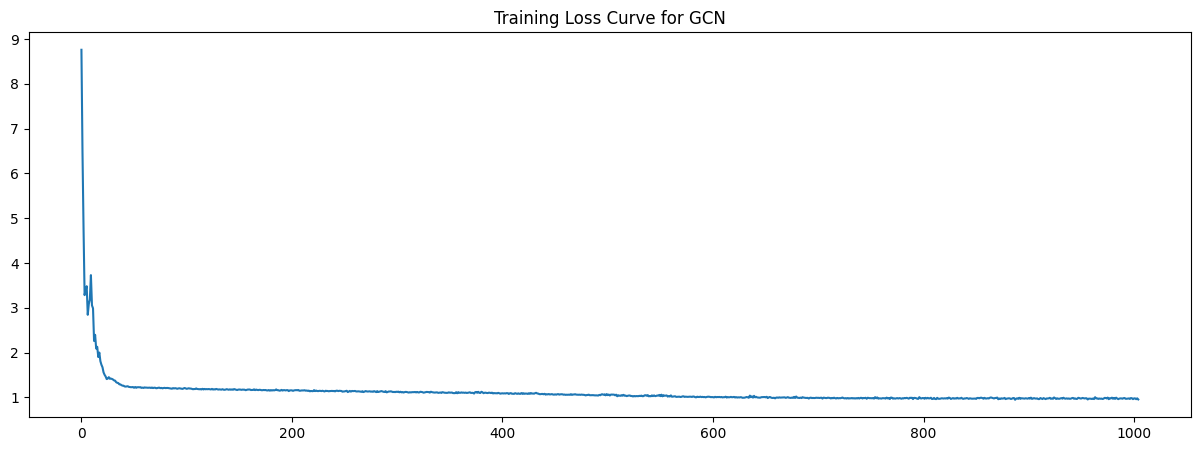

In [36]:
# plot the training curve
plot_training_curve(train_log, "GCN")

## 2.3. Train a GAT Encoder for Link Prediction (10 points)

In [37]:
# Your answer
class GATEncoder(GAT):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def forward(self, x, adj): # different argument from GAT, but kept the same as GCNEncoder
        edge_index = adj.coalesce().indices()
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)

        return z

In [38]:
print("Training for GAT")

features = data.x

emb_ch = 32
gat_encoder = GATEncoder(nfeat=features.shape[1], nhid=8, heads=8, nclass=emb_ch)  # here nclass is the embedding dimension
gat_lpm = LinkPredModel(gat_encoder, hidden_channels=emb_ch)

gat_lpm = gat_lpm.to(device)
data = data.to(device)

train_log = train(gat_lpm, data, lr=0.001, epochs=5000, patience=1000)

Training for GAT
Epoch 0, training loss: 1.4302451610565186, train acc: 0.46568891280947255, val acc: 0.5
Epoch 10, training loss: 1.3809998035430908, train acc: 0.5953982777179763, val acc: 0.5
Epoch 20, training loss: 1.3594706058502197, train acc: 0.6088536060279871, val acc: 0.5
Epoch 30, training loss: 1.3347548246383667, train acc: 0.6336562612127736, val acc: 0.5
Epoch 40, training loss: 1.317178726196289, train acc: 0.626210979547901, val acc: 0.5
Epoch 50, training loss: 1.3080469369888306, train acc: 0.6319070685324721, val acc: 0.5
Epoch 60, training loss: 1.2890005111694336, train acc: 0.6440168640114818, val acc: 0.5
Epoch 70, training loss: 1.2768316268920898, train acc: 0.6473358449946178, val acc: 0.5
Epoch 80, training loss: 1.257333517074585, train acc: 0.6568442770003589, val acc: 0.5
Epoch 90, training loss: 1.258871078491211, train acc: 0.6531664872622892, val acc: 0.5
Epoch 100, training loss: 1.2446258068084717, train acc: 0.6579207032651597, val acc: 0.499685929

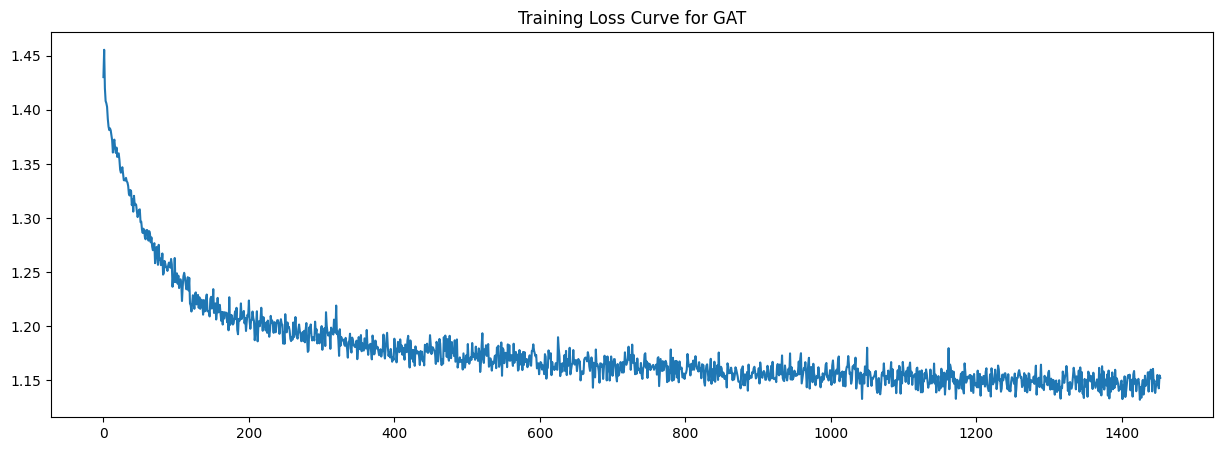

In [39]:
# plot the training curve
plot_training_curve(train_log, "GAT")

## 2.4. GCN vs. GAT Comparison (10 points)

In [40]:
# Your answer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

def evaluate_node_classification(embedding_matrix, labels, train_idx, val_idx,
                                 test_idx, normalize_embedding=True, max_iter=5000):

    """ Train a linear model (e.g., a fnn model) to predict the label of a node

    Return
    ----
    preds: the predicted labels by the model
    test_acc: the test accuracy 
    """
    ######################################
    if normalize_embedding:
         embedding_matrix = normalize(embedding_matrix, axis=1)
    
    X_train = embedding_matrix[train_idx]
    y_train = labels[train_idx]

    X_val = embedding_matrix[val_idx]
    y_val = labels[val_idx]

    X_test = embedding_matrix[test_idx]
    y_test = labels[test_idx]

    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, preds)


    ######################################
    return preds, test_acc

In [41]:
adj = graph['adj']
edge_index = torch.tensor(adj).nonzero().t().contiguous()
adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes)
adj_norm = sparse_mx_to_torch_sparse_tensor(adj)

In [42]:
with torch.no_grad():
    gcn_lpm.eval()
    emb_gcn = gcn_lpm.encoder(data.x, adj_norm)

preds, test_acc = evaluate_node_classification(emb_gcn, label, train_index, val_index, test_index)
print(f"GCN Test Accuracy: {test_acc}")

GCN Test Accuracy: 0.037181409295352325


In [43]:
with torch.no_grad():
    gat_lpm.eval()
    emb_gat = gat_lpm.encoder(data.x, adj_norm)

preds, test_acc = evaluate_node_classification(emb_gat, label, train_index, val_index, test_index)
print(f"GAT Test Accuracy: {test_acc}")

GAT Test Accuracy: 0.06446776611694154


# 3. Bonus question (10 points)
## Use the best techniques you’ve learned in class to improve the classification performance of GCN/GAT/GraphSAGE. Report your code and results below 

In [ ]:
# your best model
from torch_geometric.nn import BatchNorm

class GCNPro(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True, negative_slope=0.2):

        super().__init__()

        self.nfeat = nfeat
        self.nclass = nclass
        self.gc1 = GraphConvolution(nfeat, nhid, with_bias=with_bias)
        self.bn1 = BatchNorm(nhid) # we add a batch norm
        self.gc2 = GraphConvolution(nhid, nclass, with_bias=with_bias)
        self.dropout = dropout
        self.negative_slope = negative_slope

    def forward(self, x, adj):
        ######################################
        # write your code here 
        # hint: you can use F.dropout() function to define dropout 
        h = self.gc1(x, adj)
        h = self.bn1(h)
        h = F.leaky_relu(h, negative_slope=self.negative_slope) # we use leaky relu
        h = F.dropout(h, p=self.dropout, training=self.training)
        predicts = self.gc2(h, adj)

        ######################################
        return F.log_softmax(predicts, dim=1)

In [49]:
# define a new train function with different optimizer
def train(model, data, adj, lr=0.01, weight_decay=5e-4, epochs=200, patience=5):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) # use adamw than adam
    labels = data.y
    train_mask = data.train_mask 

    best_val_acc = 0
    best_val_epoch = 0
    best_model_state = None
    patience_counter = 0

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data.x, adj)

        loss = F.nll_loss(output[train_mask], labels[train_mask]) # compute training loss

        
        loss.backward()
        optimizer.step()

        # validate each epoch
        _, _, acc_val, loss_val = validation(model, data, adj, verbose=False)


        if i % 10 == 0:
            print(f"Epoch {i}, training loss: {loss.item()}, val loss: {loss_val}, val_acc: {acc_val}")
            # print('Epoch {}, training loss: {}, '.format(i, loss.item()))

        # early stopping
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_val_epoch = i
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {best_val_epoch} with validation accuracy {best_val_acc:4f}")
            break

    if best_model_state is not None: 
        model.load_state_dict(best_model_state)

@torch.no_grad()
def test(model, data, adj):
    """test the performance"""
    model.eval() # eval() 
    test_mask = data.test_mask
    labels = data.y 
    output = model(data.x, adj) #  
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) #  
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() #  
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()

@torch.no_grad()
def validation(model, data, adj, verbose=True):
    """add a validation for early stopping"""
    model.eval() # eval() 
    val_mask = data.val_mask
    labels = data.y 
    output = model(data.x, adj) #  
    loss_val = F.nll_loss(output[val_mask], labels[val_mask])
    preds = output[val_mask].argmax(1) #  
    acc_val= preds.eq(labels[val_mask]).cpu().numpy().mean() #  
    
    if verbose:
        print("Val set results:",
            "loss= {:.4f}".format(loss_val.item()),
            "accuracy= {:.4f}".format(acc_val))
    return preds, output, acc_val.item(), loss_val.item()

In [50]:
dataset

{'data_clip': Data(x=[5146, 512], edge_index=[2, 15924], y=[5146], train_mask=[986], val_mask=[825], test_mask=[3335]),
 'data_cnn': Data(x=[5146, 256], edge_index=[2, 15924], y=[5146], train_mask=[986], val_mask=[825], test_mask=[3335])}

In [53]:
gcnpro_models = {}
for name, data in dataset.items():
    print(f"Training GCNPro with {name}")

    num_nodes = data.x.shape[0]
    adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=num_nodes)
    adj_norm = sparse_mx_to_torch_sparse_tensor(adj)

    features = data.x
    labels = data.y

    nclass = labels.max().item()+1
    gcnpro = GCNPro(nfeat=features.shape[1], nhid=16, nclass=nclass)
    gcnpro = gcnpro.to(device)
    data = data.to(device)
    adj_norm = adj_norm.to(device)
    train(gcnpro, data, adj_norm, lr=0.0005, epochs=5000, patience=1000)

    gcnpro_models[name] = gcnpro

    print("="*20)


Training GCNPro with data_clip
Epoch 0, training loss: 6.8644795417785645, val loss: 15.570046424865723, val_acc: 0.06060606060606061
Epoch 10, training loss: 5.586727142333984, val loss: 5.232656955718994, val_acc: 0.06787878787878789
Epoch 20, training loss: 4.64836311340332, val loss: 3.940659523010254, val_acc: 0.055757575757575756
Epoch 30, training loss: 3.9385101795196533, val loss: 3.663271188735962, val_acc: 0.05696969696969697
Epoch 40, training loss: 3.6463119983673096, val loss: 3.36875057220459, val_acc: 0.06909090909090909
Epoch 50, training loss: 3.4768364429473877, val loss: 3.246875047683716, val_acc: 0.07757575757575758
Epoch 60, training loss: 3.245399236679077, val loss: 3.2284910678863525, val_acc: 0.06545454545454546
Epoch 70, training loss: 3.2208173274993896, val loss: 3.1910808086395264, val_acc: 0.07393939393939394
Epoch 80, training loss: 3.2024238109588623, val loss: 3.099337339401245, val_acc: 0.08121212121212121
Epoch 90, training loss: 3.1084117889404297,

In [56]:
# test models
for name, model in gcnpro_models.items():
    print(f"Testing GCNPro with {name}")
    data = dataset[name]

    num_nodes = data.x.shape[0]
    adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=num_nodes)
    adj_norm = sparse_mx_to_torch_sparse_tensor(adj)

    test(model, data, adj_norm)
    print("="*20)

Testing GCNPro with data_clip
Test set results: loss= 2.9614 accuracy= 0.1685
Testing GCNPro with data_cnn
Test set results: loss= 3.4490 accuracy= 0.2138
